In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [4]:
stock_symbol = 'RELIANCE.NS'

In [5]:
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [6]:
type(data)

pandas.core.frame.DataFrame

In [7]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-16,1229.777466,1243.492432,1225.205811,1228.634644,1203.933228,8680158
2019-04-18,1257.207520,1270.693848,1248.064209,1267.219482,1241.742432,19643267
2019-04-22,1243.492432,1249.892822,1226.394531,1230.097534,1205.366821,11803961
2019-04-23,1232.520508,1255.378784,1230.691895,1247.012695,1221.941895,9903725
2019-04-24,1252.910156,1275.311279,1249.207031,1270.465332,1244.923096,8050556


In [8]:
len(data)

1235

In [9]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-09,2978.000000,2979.600098,2925.000000,2927.300049,2927.300049,3535707
2024-04-10,2932.699951,2974.000000,2932.699951,2959.149902,2959.149902,4569165
2024-04-12,2951.750000,2972.949951,2926.149902,2934.300049,2934.300049,7775506
2024-04-15,2922.000000,2964.250000,2892.649902,2929.649902,2929.649902,6451031
2024-04-16,2906.699951,2942.350098,2901.850098,2931.500000,2931.500000,4683092


In [10]:
opn = data[['Open']]

<Axes: xlabel='Date'>

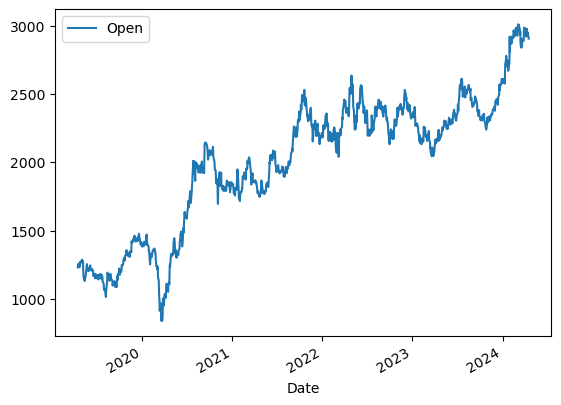

In [11]:
opn.plot()

In [12]:
ds = opn.values

In [13]:
ds

array([[1229.77746582],
       [1257.20751953],
       [1243.49243164],
       ...,
       [2951.75      ],
       [2922.        ],
       [2906.69995117]])

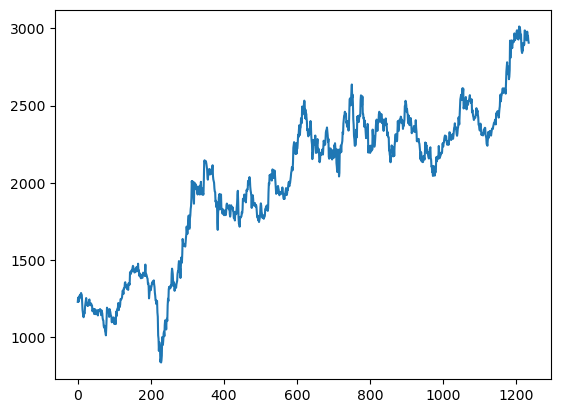

In [14]:
plt.plot(ds)

In [15]:
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [16]:
len(ds_scaled), len(ds)

(1235, 1235)

In [17]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [18]:
train_size,test_size

(864, 371)

In [19]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [20]:
len(ds_train),len(ds_test)

(864, 371)

In [21]:
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [22]:
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [23]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [24]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [25]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [26]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

D:\anaonda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - loss: 0.1077 - val_loss: 0.0424
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0124 - val_loss: 0.0024
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0032 - val_loss: 0.0070
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:
model.save('keras_stocks_model.keras')


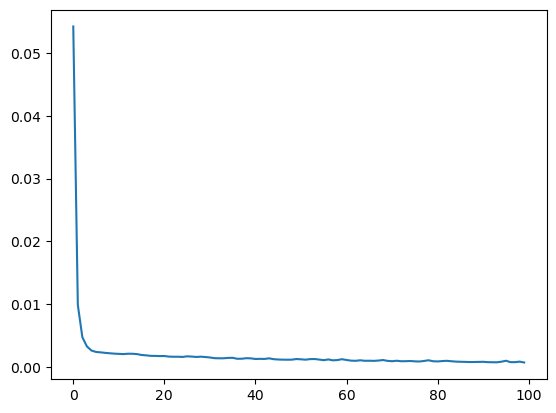

In [30]:
loss = model.history.history['loss']
plt.plot(loss)

In [31]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [32]:
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

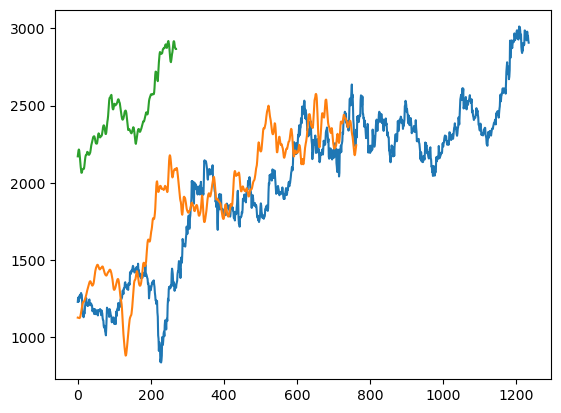

In [33]:
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [34]:
type(train_predict)

numpy.ndarray

In [35]:
test = np.vstack((train_predict,test_predict))

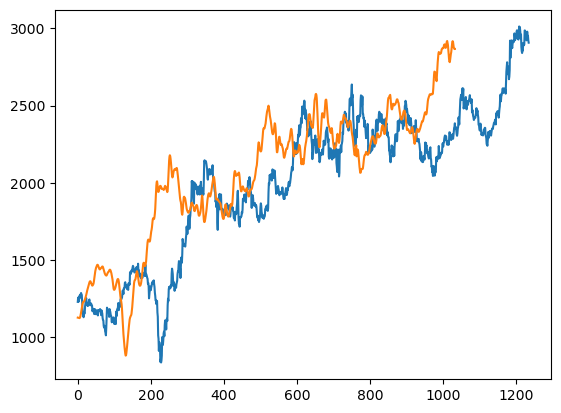

In [36]:
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [37]:
len(ds_test)

371

In [38]:
fut_inp = ds_test[270:]

In [39]:
fut_inp = fut_inp.reshape(1,-1)

In [40]:
tmp_inp = list(fut_inp)

In [41]:
fut_inp.shape

(1, 101)

In [42]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [43]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(tmp_inp) > n_steps):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp = fut_inp.reshape(1, -1)
        fut_inp = fut_inp.reshape((1, fut_inp.shape[1], 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        fut_inp = np.array(tmp_inp)
        fut_inp = fut_inp.reshape((1, len(tmp_inp), 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[[0.9280118942260742], [0.9192860722541809], [0.9080201983451843], [0.8961177468299866], [0.884631335735321], [0.8740744590759277], [0.8646721243858337], [0.8564984202384949], [0.8495383262634277], [0.8437169194221497], [0.8389173150062561], [0.8349950313568115], [0.8317910432815552], [0.8291431665420532], [0.8268958330154419], [0.8249077796936035], [0.823056697845459], [0.821243405342102], [0.819392204284668], [0.8174513578414917], [0.8153908848762512], [0.8132002353668213], [0.8108848929405212], [0.8084622025489807], [0.8059588074684143], [0.8034055829048157], [0.8008356094360352], [0.798281192779541], [0.7957713603973389], [0.7933308482170105]]


In [44]:
len(ds_scaled)

1235

In [45]:
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [46]:
ds_new = ds_scaled.tolist()

In [47]:
len(ds_new)

1235

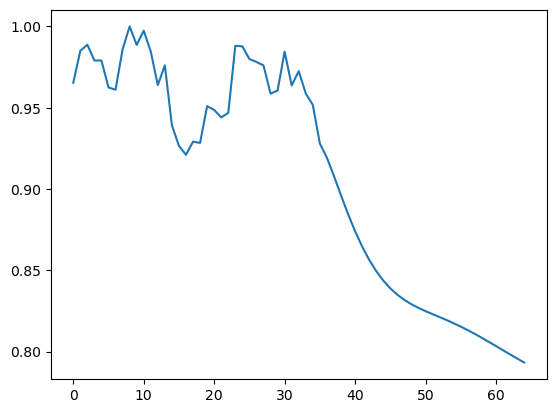

In [48]:
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [49]:
final_graph = normalizer.inverse_transform(ds_new).tolist()

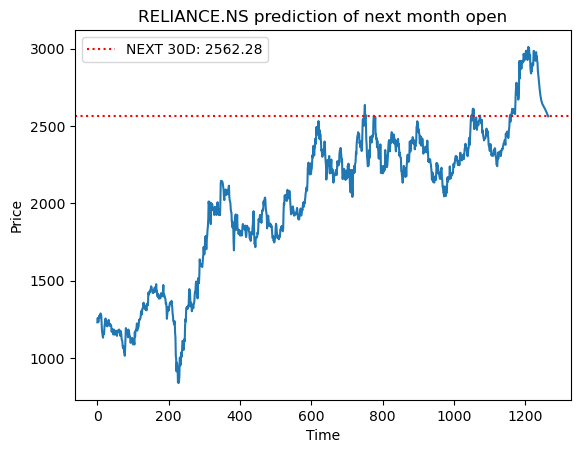

In [50]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

